In [14]:
# Imports as always.
import os
import re
import csv
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

from hflayers import HopfieldLayer

from datetime import datetime

from tqdm.notebook import tqdm

from data_handling import ISICDataset

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

# Beautification.
sns.set_context('paper')
sns.set_style('darkgrid')
sns.set_palette('Spectral')

print(f'CUDA is available for use with PyTorch: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    torch.set_default_device('cuda')

print(f'Installed Python version:  {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')
print(f'Installed PyTorch version: {torch.__version__}')

# Helper function to send a tensor/model/etc. to the CPU/GPU accordingly.
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()
    
# Helper function for closing figures.
def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()
        
# Get the current data and time as a string.
date_string = datetime.now().strftime('%Y-%m-%d-(%H-%M-%S)')

print(f'Date: {date_string}')

CUDA is available for use with PyTorch: True
Installed Python version:  3.8.18
Installed PyTorch version: 2.1.2+cu121
Date: 2024-03-13-(19-09-20)


# Hopfield as Pre-processing

[Here's](https://epub.jku.at/obvulihs/download/pdf/8080454?originalFilename=true) a good paper using these new layers.

This notebook considers the use of the new Hopfield layers as a pre-processing technique to preemptively reconstruct data for use in an otherwise standard pipeline.

We consider a few ways for going about this:
- **Pre-trained Hopfield**: The Hopfield pre-processing unit is independently pre-trained on a reconstructive task, then prepended onto a SegNet model for image segmentation. There is then some fine-tuning, wherein the SegNet's parameters are trained from scratch in tandem with the possibility for change in the Hopfield's parameters.
- **Pre-trained model**: The Hopfield pre-processing unit is prepended onto a model (SegNet) that has already been trained for image segmentation. Again, there is then a fine-tuning process. This is the setup we are most interested in practice, as we could train the SegNet on clean data to become competent at segmentation, then train the Hopfield + SegNet model on damaged data to understand whether it may be possible to recover performance by having a Hopfield learn to reconstruct damage. This setup also allows us to consider the implication of the Hopfield in isolation, uncovering the immediate effect of its introduction.
- **End-to-end training from scratch**: Again, we prepend a Hopfield pre-processing unit to a model (SegNet), though all weights are trained from scratch for the end-to-end image segmentation task. This is compatible with both train- and test-time reconstruction (unlike a pre-trained model, which is surely incapable of pre-training on damaged data). This is expected to be the worst performing variant, though success in this setup would be a fantastic result for memory-like pre-processing in neural networks.

From the original work, it is not entirely clear how to go about getting the Hopfield layers to do this. Let's discuss which layer seems most appropriate for this kind of reconstructive pre-processing.

### The `Hopfield` Layer

The `Hopfield` layer is designed for associating and processing two sets (equivalent to transformer attention, which associates keys and queries). In our case, this could be reduced to associating clean images (as stored keys) with damaged variants (as probing queries).

This is the most general form, where the result patterns $Z$ are functions of raw stored patterns $Y$, raw state patterns $R$, and possibly projection matrices $W_Q$, $W_K$, and $W_V$ (for query, key, and value). Specifically, 
$$
Z=\text{softmax}(\beta\cdot RW_QW_K^TY^T)YW_KW_V\ .
$$

The $N$ stored raw patterns $Y=(\mathbf{y}_1,\dots,\mathbf{y}_N)^T$ and the $S$ raw state patterns $R=(\mathbf{r}_1,\dots,\mathbf{r}_S)^T$ are mapped to an associative space (by matrices $W_K$ and $W_Q$). The flexibility of this layer (over transformers, for example) is that we may use *static* state and stored patterns -- they do not have to depend on network input.

Here is an illustration of the above equation (with $W_V:=W_KW_V$ for simplicity):

![Hopfield layer diagram](./hopfield_equation_diagram.png)

For this example, the implementation looks as follows:

```
hopfield = Hopfield(
    input_size = 3,                 # R
    hidden_size = 3,
    stored_pattern_size = 4,        # Y
    pattern_projection_size = 4,    # Y
    scaling = beta
)

# tuple of stored_pattern, state_pattern, pattern_projection.
hopfield((Y, R, Y))
```

### The `HopfieldPooling` Layer

The `HopfieldPooling` layer is designed for fixed pattern search, pooling operations, and memories like LSTMs or GRUs. The state (i.e. query) pattern is static, and may be learned during training.

If only one static state pattern (i.e. query) exists, the this is de facto a pooling over the sequence. This static state pattern is considered a "prototype pattern" and consequently learned in the Hopfield pooling layer. Note that the pooling always operates over the *token* dimension  (i.e. the sequence length), not the embedding dimension.

Here is an example of a pooling operation $Y\in\mathbb{R}^{(3\times5)}\to Z\in\mathbb{R}^{(2\times5)}$:

![Hopfield pooling diagram](./hopfield_pooling_diagram.png)

```
hopfield_pooling = HopfieldPooling(
    input_size=4,       # Y
    hidden_size=3,      # Q
    scaling=beta,
    quantity=2)         # No. state patterns

# Stored_pattern and pattern_projection
hopfield_pooling(Y)
```

### The `HopfieldLayer` Layer

The `HopfieldLayer` layer is designed to store fixed patterns or learning internal prototypes. Of course, the stored (i.e. key) patterns are static and can be learned during training. 

On such use of this layer is "lookup"; we employ a trainable but input-independent lookup mechanism. Internally, stored patterns and pattern projections are trained, which in turn are used as a lookup mechanism independent of the input data.

![Hopfield for lookup diagram](./hopfield_for_lookup_diagram.png)

```
hopfield_lookup = HopfieldLayer(
    input_size=3,                   # R
    hidden_size=3,                  # W_K
    pattern_size=4,                 # W_V
    quantity=4,                     # W_K
    scaling=beta,
    stored_pattern_as_static=True,
    state_pattern_as_static=True)           

# State pattern.
hopfield_lookup(R)
```

This specialised variant of `HopfieldLayer` allows for a setting wherein the training data are used as stored patterns, the new data as state patterns, and the training labels to project the output of the layer.

```
hopfield_lookup = HopfieldLayer(
    input_size=3,                           # R
    hidden_size=3,                          # W_K
    quantity=4,                             # W_K
    scaling=beta,
    lookup_weights_as_separated=True,
    lookup_targets_as_trainable=False,
    stored_pattern_as_static=True,
    state_pattern_as_static=True,
    pattern_projection_as_static=True)      

# state pattern
hopfield_lookup(R)
```

## Data Handling

In [2]:
# Pre-define a couple of transform functions to and from tensors and images.
tensor_to_image = transforms.ToPILImage()
image_to_tensor = transforms.ToTensor()

In [3]:
# Change this as necessary. Unzip all downloaded data into this directory, keeping default naming.
data_directory = './data/ISIC2018/'

# Define the train dataset.
train_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Training_Input',
    target_path='ISIC2018_Task1_Training_GroundTruth',
    transform=True,
    image_width=128, image_height=128,
)

# Define the validate dataset.
val_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Validation_Input',
    target_path='ISIC2018_Task1_Validation_GroundTruth',
    transform=True,
    image_width=128, image_height=128
)

# Package into data loaders.
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

## Using `HopfieldLayer` to Learn to Restore Damaged Images

[This](https://arxiv.org/pdf/2208.04441.pdf) paper has a model using these layers for something with images (though not segmentation). Here is a figure they give (ignore the reference to text-image embeddings)

![HopfieldLayer diagram](./hopfieldlayer_diagram.png)

Prototype learning can be achieved from two perspectives: (1) learning the most representative prototypes and saving the stored patterns in $W_\text{content}$ (each row -- although I reckon column -- corresponds to a learned prototype of *something*); and (2) learning to represent the input embedding features $X$ with the learned prototypes using the prototype lookup matrix $W_\text{lookup}$. It follows then that $\text{softmax}(\beta XW^T_\text{lookup})$ can be interpreted as the probability distribution over each prototype in the mapping.

`HopfieldLayer` only takes state patterns (i.e. queries) as input. The stored patterns (i.e. keys) can a learnable matrix, a predefined reference set (e.g. the training set), or, most interestingly, can be initialised by a reference set *and then learnt*.

This layer is designed for a retrieval task, and we hope that by allowing the stored patterns to be learned, with the training set as a starting point, we are able to fill the network's associative memory space with its understanding of what lesions look like. 

Moreover, if we initialise with perfect training data, then we could plausibly train immediately with damaged data without too much difficulty. Though, to be fair, the initialising data should not be used in training if we were to do this, unless we would like to indicate that it is our outright intention for the model to learn how data are damaged. This is, however, a different idea to doing lesion segmentation with data that happen to be damaged. **For the time being, we initialise randomly (as we normally would) because I have no idea how to initialise to the training set**, especially when we are learning *patches*, not full images.

### Encoding

This subnetwork will convert our channeled images into 1-D sequences. We use the same process as used in the vision transformer (ViT): images are split into fixed-size patches, then linearly projected into a 1-D associative space by a learnable matrix $W_E$. It appears that each projected patch should belong to its own column in $Y$, and the rows of $Y$ are representative of the embedding features.

We should also incorporate a positional encoding into the embedding. [Here's](https://github.com/nerminnuraydogan/vision-transformer/blob/main/vision-transformer.ipynb) a great notebook going through how embeddings work in the vision transformer (ViT). [This](https://github.com/lanl/vision_transformers_explained/blob/main/notebooks/PositionEmbeddingExplained.ipynb) is another great notebook discussing the need for positional embeddings in attention-based architectures.

While many works report higher accuracy in models using position embeddings, there is an overall lack of evidence supporting any one type of position embedding over another. Here are a few fan favourites:
- In the famous *Attention is All You Need* paper, a **fixed sinusoidal positional embedding** is used, noting that they observe "nearly identical results" between learned and fixed position embeddings. Although, this work was designed for NLP tasks, and sought varying phrase lengths, making it less clear whether these same findings apply in our visual domain.
- The paper *An Image is Worth 16x16 Words* (the ViT paper), positional embeddings are applied to images, with ablation studies being run on four different types in both fixed and learnable settings. They find little difference between their different types, or between fixed and learnable, though show a significant performance advantage to using *some* kind of positional embedding. So, again, they're great, and the exact nature of the method appears to be of little consequence.

It might be a nice safe bet to go with the likes of *Attention is All You Need* and *Tokens-to-Token ViT: Vision Transformers from Scratch on ImageNet* in going with a sinusoidal position embedding;
$$
\theta_{ij}=\frac{i}{10000^{2jd^{-1}}}\ ,\phantom{\int}\text{PE}_{(i,2j)}=\sin(\theta_j)\ ,\phantom{\int}\text{PE}_{(i,2j+1)}=\cos(\theta_{ij})\ ,
$$
where $\text{PE}$ is the position embedding matrix, $i$ is along the number of tokens, $j$ is along the total length of the tokens, and $d$ is the token length.

In [4]:
def get_sinusoidal_encoding(n_tokens, token_length):
    def get_position_angle_vector(i):
        return [i / np.power(10000, 2 * (j // 2) / token_length) for j in range(token_length)]

    table = np.array([get_position_angle_vector(i) for i in range(n_tokens)])
    table[:, 0::2] = np.sin(table[:, 0::2])
    table[:, 1::2] = np.cos(table[:, 1::2])

    return torch.cuda.FloatTensor(table).unsqueeze(0)

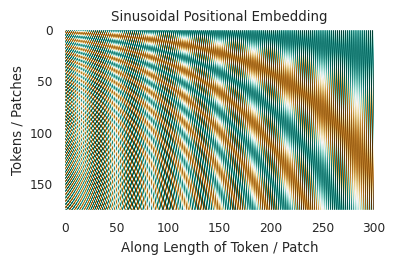

In [6]:
# Example.
PE = get_sinusoidal_encoding(n_tokens=176, token_length=768).detach().cpu()

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(PE[0, :, 0:301], cmap='BrBG')
ax.set_title('Sinusoidal Positional Embedding')
ax.set_xlabel('Along Length of Token / Patch')
ax.set_ylabel('Tokens / Patches')
ax.grid(alpha=0)
plt.savefig('./misc-figures/sinusoidal-positional-embedding-example.pdf', bbox_inches='tight')

In [6]:
# Sequence-embedding network.
class Embedding(nn.Module):
    def __init__(self, image_size, patch_size, channels, embed_dim):
        super().__init__()
        self.image_size = int(image_size)
        self.patch_size = int(patch_size)
        self.channels = int(channels)
        self.embed_dim = int(embed_dim)
        
        # Trainable linear projection for mapping dimension of patches.
        self.W_E = nn.Parameter(torch.randn(self.patch_size * self.patch_size * self.channels, self.embed_dim))
        
        # Fixed sinusoidal positional embedding.
        self.n_patches = self.image_size ** 2 // self.patch_size ** 2
        self.PE = get_sinusoidal_encoding(n_tokens=self.n_patches, token_length=self.embed_dim)
        
    def forward(self, x):
        # Patching.
        patches = x.unfold(1, self.channels , self.channels).unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(patches.size(0), -1, self.channels  * self.patch_size * self.patch_size).float()
        
        # Patch embeddings.
        patch_embeddings = torch.matmul(patches, self.W_E)
        
        # Position embeddings.
        embeddings = patch_embeddings + self.PE
        
        # Transpose so that each column represents a patch embedding.
        embeddings = torch.transpose(embeddings, 1, 2)
        
        return embeddings
    
# Shape check.
channels, image_size, patch_size, embed_dim = 3, 64, 16, 768
embedding_layer = Embedding(image_size, patch_size, channels, embed_dim)
x = torch.randn(batch_size, channels, image_size, image_size)
y = embedding_layer(x)
print(f'Embedding layer: input shape {x.shape} -> output shape {y.shape}')

Embedding layer: input shape torch.Size([8, 3, 64, 64]) -> output shape torch.Size([8, 768, 16])


### Decoding

Again, we'll make this learnable. And *again* again, we do as in ViT -- a linear projection and folding into the shape of an image.

In [7]:
class OutputProjection(nn.Module):
    def __init__(self, image_size, patch_size, embed_dim, output_dim):
        super().__init__()
        
        # Linear projection to take us from the association space to the full output space.
        self.projection = nn.Linear(embed_dim, patch_size * patch_size * output_dim)
        
        # And fold into an image shape.
        self.fold = nn.Fold(output_size=(image_size, image_size), kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        # We transposed at the end of the encoder, so we must transpose at the start of the decoder.
        x = torch.transpose(x, 1, 2)
        
        # Project.
        x = self.projection(x)
        
        # Fold into shape.
        x = x.permute(0, 2, 1)
        x = self.fold(x)
        
        return x
    
# Shape check.
channels, image_size, patch_size, embed_dim = 3, 64, 16, 768
output_layer = OutputProjection(image_size, patch_size, embed_dim, output_dim=channels)
x = torch.randn(batch_size, embed_dim, (image_size//patch_size)**2)
y = output_layer(x)
print(f'Output layer: input shape {x.shape} -> output shape {y.shape}')

Output layer: input shape torch.Size([8, 768, 16]) -> output shape torch.Size([8, 3, 64, 64])


### Getting the `HopfieldLayer` working

To get the layer working, we'll try to train the lookup for masking repair: we will mask the input to a model comprising `Embedding`, `HopfieldLayer`, `OutputProjection` (possibly repeating) and train the output to replicate the unmasked image as closely as possible.

The loss for this task should measure the difference between the true unmasked image and the reconstructed image. I think a good loss function for doing that is `MSELoss(reduction='sum')`.

In [8]:
# What should all the arguments be?
hopfield_layer = HopfieldLayer(
    input_size=16,
    quantity=16,
    lookup_targets_as_trainable=True,
    stored_pattern_as_static=True,
    state_pattern_as_static=True,
    pattern_projection_as_static=True
)

# Shape check.
channels, image_size, patch_size, embed_dim = 3, 64, 16, 768
x = torch.randn(batch_size, embed_dim, (image_size//patch_size)**2)
y = hopfield_layer(x)
print(f'Hopfield layer: input shape {x.shape} -> output shape {y.shape}')

Hopfield layer: input shape torch.Size([8, 768, 16]) -> output shape torch.Size([8, 768, 16])


### Putting it together

In [9]:
# Self-attention layer.
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        x = torch.transpose(x, 1, 2)
        
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        
        weighted = torch.transpose(x, 1, 2)
        
        return weighted
    
# Shape check.
channels, image_size, patch_size, embed_dim = 3, 64, 16, 768
attention_layer = SelfAttention(input_dim=embed_dim)
x = torch.randn(batch_size, embed_dim, (image_size//patch_size)**2)
y = attention_layer(x)
print(f'Self-attention layer: input shape {x.shape} -> output shape {y.shape}') 

Self-attention layer: input shape torch.Size([8, 768, 16]) -> output shape torch.Size([8, 768, 16])


In [10]:
model = nn.Sequential(
    # Learnable embedding layer (with fixed positional embeddings).
    Embedding(
        image_size=128, 
        patch_size=4, 
        channels=3, 
        embed_dim=768
    ),
    
    # Learnable Hopfield lookup layer.
    HopfieldLayer(
        # Input size should be the number of patches (image_size // patch_size) ** 2.
        input_size=1024,
        # Quantity is the number of stored patterns (keys), and I have no idea what to set this as.
        quantity=16,
        # Can we ignore hidden size and pattern size? Surely these are fixed by input size and quantity for the matrix multiplication to be legal?
        
        # We must specify that the stored and state patterns (keys and values) are static.
        lookup_targets_as_trainable=True,
        stored_pattern_as_static=True,
        state_pattern_as_static=True,
        pattern_projection_as_static=True
        
        # Having the stored patterns (keys) be initialised as a subset of the training set is its own challenge that we'll tackle another time.
    ),
    
    # Self-attention layer.
    SelfAttention(
        input_dim=embed_dim
    ),
    
    OutputProjection(
        image_size=128, 
        patch_size=4, 
        embed_dim=768,
        # Because we are reconstructing an image, the number of output dimensions is the channels.
        output_dim=3
    )
)

# Shape check.
channels, image_size, patch_size, embed_dim = 3, 128, 4, 768
x = torch.randn(batch_size, channels, image_size, image_size)
y = model(x)
print(f'Hopfield lookup for reconstruction: input shape {x.shape} -> output shape {y.shape}')

Hopfield lookup for reconstruction: input shape torch.Size([8, 3, 128, 128]) -> output shape torch.Size([8, 3, 128, 128])


In [4]:
# Function for comparing masked, reconstructed, and original side-by-side.
def side_by_side_model_comparison(model, x, y_true, i_to_plot=0):
    # We expect x.shape is (batch_size, channels, height, width), and that height = width.
    batch_size, channels, image_size, _ = x.shape
    
    # Get the model output.
    model.eval()
    y_pred = model(x)
    
    # Show them.
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(x[i_to_plot].detach().cpu().permute(1, 2, 0))
    ax2.imshow(y_pred[i_to_plot].detach().cpu().permute(1, 2, 0))
    ax3.imshow(y_true[i_to_plot].detach().cpu().permute(1, 2, 0))
    
    # Beautify.
    ax1.axis('off')
    ax1.axis('tight')
    ax1.axis('image')
    ax2.axis('off')
    ax2.axis('tight')
    ax2.axis('image')
    ax3.axis('off')
    ax3.axis('tight')
    ax3.axis('image')
    
    ax1.set_title('Damaged Image')
    ax2.set_title('Reconstructed Image')
    ax3.set_title('Original Image')
    
    plt.show()

In [5]:
from matplotlib.gridspec import GridSpec

from copy import deepcopy

# Mask the bottom of an image.
def mask_image(image):
    masked_image = deepcopy(image)
    _, height, _ = image.shape
    
    masked_image[:, height // 2 : height, :] = 0
    return masked_image

def damage_image(image, damage_degree=.1):
    masked_image = deepcopy(image)
    _, height, _ = image.shape
    
    # Randomly zero damage_degree% of pixels to damage. We consider all channels together -- damaging pixels.
    zero_indices = np.random.choice(height * height, int(height * height * damage_degree), replace=False)
    for idx in zero_indices:
        x, y = np.divmod(idx, height)
        masked_image[:, x, y] = 0
    
    return masked_image

# Show an example plot for the model.
def example_restoration(model, clean_image, damage_degree=.25):
    # Damage the image.
    damaged_image = damage_image(clean_image, damage_degree).reshape([1, 3, 128, 128]).to('cuda')
    
    # Get the model output.
    model.eval()
    predicted_image = model(damaged_image)
    
    # Show them.
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'wspace': 0, 'hspace': 0})
    ax1.imshow(damaged_image[0].detach().cpu().permute(1, 2, 0))
    ax2.imshow(predicted_image[0].detach().cpu().permute(1, 2, 0))
    ax3.imshow(clean_image.detach().cpu().permute(1, 2, 0))
    
    # Beautify.
    ax1.axis('off')
    ax1.axis('tight')
    ax1.axis('image')
    ax2.axis('off')
    ax2.axis('tight')
    ax2.axis('image')
    ax3.axis('off')
    ax3.axis('tight')
    ax3.axis('image')
    
    ax1.set_title('Corrupted')
    ax2.set_title('Restored')
    ax3.set_title('Original')
    
     # Memory saving.
    del damaged_image
    del predicted_image

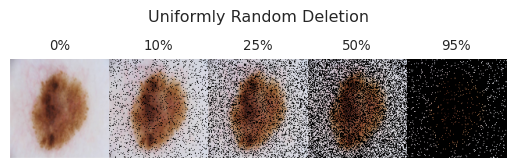

In [47]:
# Show damage degrees side-by-side.
fig, axes = plt.subplots(1, 5, gridspec_kw={'wspace': 0, 'hspace': 0})
fig.suptitle('Uniformly Random Deletion', y=.7, x=0.514)

# Get an example image.
example_idx = 6 # np.random.randint(low=0, high=len(train_dataset))
example_image = train_dataset[example_idx][0]

# Damage that image to different degrees.
damage_degrees = [.0, .1, .25, .5, .95]
for i, ax in enumerate(axes.flatten()):
    # Plot
    damage_degree = damage_degrees[i]
    ax.imshow(damage_image(example_image, damage_degree).detach().cpu().permute(1, 2, 0))
    
    # Beautify.
    ax.axis('off')
    ax.axis('tight')
    ax.axis('image')
    
    ax.set_title(f'{int(damage_degree * 100)}%')
    
plt.savefig('./misc-figures/uniform-random-deletion-example.pdf', bbox_inches='tight')

In [ ]:
damage_degree = .25

# One training epoch.
def train(model, device, train_loader, optimiser, loss_fn):
    model.train()
    train_loss = 0
    for y_true, _ in tqdm(train_loader, desc='In-epoch training'):
        x = torch.stack([damage_image(image, damage_degree) for image in y_true])
        x, y_true = x.to(device), y_true.to(device)
        
        optimiser.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y_true)
        train_loss += loss.item()
        loss.backward()
        optimiser.step()
        
        # Memory saving.
        del x
        del y_true
        del y_pred
        
    train_loss /= len(train_loader.dataset)
    
    print(f'Train loss: {train_loss:.4f}')
    return train_loss
        
# Test model.
def test(model, device, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for y_true, _ in test_loader:
            x = torch.stack([damage_image(image, damage_degree) for image in y_true])
            x, y_true = x.to(device), y_true.to(device)
            
            y_pred = model(x)
            test_loss += loss_fn(y_pred, y_true).item()
            
            # Memory saving.
            del x
            del y_true
            del y_pred

    test_loss /= len(test_loader.dataset)

    print(f'Val loss: {test_loss:.4f}')
    return test_loss
    
# Model, optimiser, scheduler, and loss function.
model = nn.Sequential(
    Embedding(image_size=128, patch_size=4, channels=3, embed_dim=768),
    HopfieldLayer(input_size=1024,quantity=2**14, lookup_targets_as_trainable=True, stored_pattern_as_static=True, state_pattern_as_static=True, pattern_projection_as_static=True),
    SelfAttention(input_dim=768),
    OutputProjection(image_size=128, patch_size=4, embed_dim=768, output_dim=3)
)
to_device(model)
optimiser = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=1, gamma=.7)
loss_fn = nn.MSELoss(reduction='sum')

# Training.
epochs = 25
train_losses = []
val_losses = []
for epoch_idx in tqdm(range(1, epochs + 1), desc='Training'):
    print(f'\nEpoch {epoch_idx}')
    train_loss = train(model, 'cuda', train_dataloader, optimiser, loss_fn)
    val_loss = test(model, 'cuda', val_dataloader, loss_fn)
    scheduler.step()
    
    # Saving just in case...
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Write stats to file.
    os.makedirs(f'./models/hopfield-pre-processing/saves/{date_string}', exist_ok=True) 
    with open(f'./models/hopfield-pre-processing/saves/{date_string}/stats.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([epoch_idx, train_loss, val_loss])
    
    # Let's have a look.
    print('Training set example...')
    random_idx = np.random.randint(low=0, high=len(train_dataset)-1)
    example_restoration(model, train_dataset[random_idx][0], damage_degree=.25)

In [16]:
# Save the model.
os.makedirs(f'./models/hopfield-pre-processing/saves/{date_string}', exist_ok=True) 
torch.save(model.state_dict(), f'./models/hopfield-pre-processing/saves/{date_string}/model-state-dict')

In [ ]:
# Read in that data.
# No

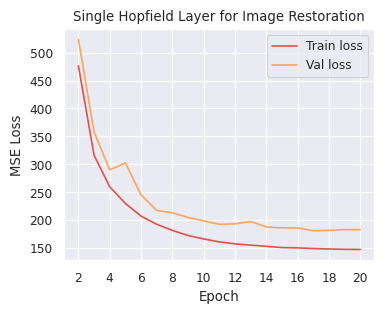

In [32]:
# Plot the loss curves.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

sns.lineplot(x=np.arange(2, 21), y=train_losses[1:], label='Train loss')
sns.lineplot(x=np.arange(2, 21), y=val_losses[1:], label='Val loss')

ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Single Hopfield Layer for Image Restoration')

ax.set_xticks(np.arange(2, 21, step=2))

plt.savefig(f'./models/hopfield-pre-processing/saves/{date_string}/loss-curves.pdf', bbox_inches='tight')

In [48]:
# Load in the model.
model = nn.Sequential(
    Embedding(image_size=128, patch_size=4, channels=3, embed_dim=768),
    HopfieldLayer(input_size=1024,quantity=2**14, lookup_targets_as_trainable=True, stored_pattern_as_static=True, state_pattern_as_static=True, pattern_projection_as_static=True),
    SelfAttention(input_dim=768),
    OutputProjection(image_size=128, patch_size=4, embed_dim=768, output_dim=3)
)
to_device(model)
model.load_state_dict(torch.load('./models/hopfield-pre-processing/saves/2024-03-10-(21-33-09)/model-state-dict'))

<All keys matched successfully>

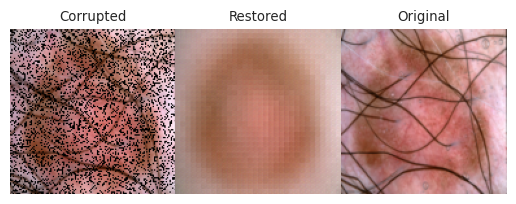

In [45]:
# Pick a validation example to show.
#random_idx = np.random.randint(low=0, high=len(val_dataset)-1)
random_idx = 11 # Some good ones to show: 3, 4, 5, 9, 10, 11 is fucking great, 19
example_restoration(model, val_dataset[random_idx][0], damage_degree=.25)
plt.savefig('./models/hopfield-pre-processing/saves/2024-03-10-(21-33-09)/example-restoration.pdf', bbox_inches='tight')

## Using a Pre-trained Hopfield Restoring Block (Above) as a Pre-processor for Segmentation

Now we use the above block as a pre-processor for restoring incoming damaged data. The output from this block is then the input to a standard model (e.g. SegNet, CNN, etc.) for image segmentation.

It is often the case that pre-trained models are fine-tuned, but I do not think that is something we would like. As such, we will use the Hopfield restoration block to independently repair the data, then train the rest of the model on this output data, only changing the gradients in this secondary model.

There are a few things I would like to try, all using a pre-trained Hopfield restoration model:
- Training the secondary model from scratch on these repaired data.
- Evaluating the *recovered* performance by training a model on the clean data, then comparing the model's performance on damaged data and on repaired data to see if using the Hopfield as a pre-processor has recovered the performance the secondary model would achieve on clean data.
- Initialising the secondary model's weights from its weights after training on clean data, then continuing to train on the repaired data to act as fine-tuning.

In [6]:
from models.hopfield_restoration import build_hopfield_restoration_block
from models.image_segmentation import SegmentationModel

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


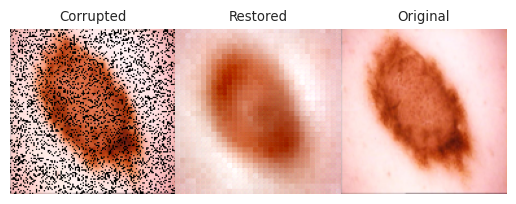

In [7]:
# Load in the Hopfield restoration model.
hopfield_restoration_model = build_hopfield_restoration_block(
    image_size=128,
    patch_size=4,
    channels=3,
    embed_dim=768,
    stored_patterns=2**14
)
to_device(hopfield_restoration_model)
hopfield_restoration_model.load_state_dict(torch.load('./models/hopfield-pre-processing/saves/2024-03-10-(21-33-09)/model-state-dict'))

# Pick a validation example to show.
random_idx = 19
example_restoration(hopfield_restoration_model, val_dataset[random_idx][0], damage_degree=.25)

In [8]:
# Define the secondary model.
secondary_model = SegmentationModel()
to_device(secondary_model)

SegmentationModel(
  (model): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
 

In [9]:
# Demonstrate model's segmentation.
def side_by_side_model_segmentation(model, example_sample, cmap='bone'):
    # Break apart the sample and move to device.
    example_input, example_target = example_sample
    example_input = example_input.reshape(1, 3, 128, 128).to('cuda')
    example_target = example_target.to('cuda')
    example_output, _ = model(example_input, example_target)
    
    # Show them.
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'wspace': 0, 'hspace': 0})
    ax1.imshow(example_input[0].detach().cpu().permute(1, 2, 0))
    ax2.imshow(example_output[0].detach().cpu().permute(1, 2, 0), cmap=cmap)
    ax3.imshow(example_target[0].detach().cpu(), cmap=cmap)
    
    # Memory saving.
    del example_sample
    del example_input
    del example_target
    del example_output
    
    # Beautify.
    ax1.axis('off')
    ax1.axis('tight')
    ax1.axis('image')
    ax2.axis('off')
    ax2.axis('tight')
    ax2.axis('image')
    ax3.axis('off')
    ax3.axis('tight')
    ax3.axis('image')
    
    ax1.set_title('Corrupted Input')
    ax2.set_title('Predicted Mask')
    ax3.set_title('True Mask')

### From-scratch secondary training

In [10]:
# Change this as necessary. Unzip all downloaded data into this directory, keeping default naming.
data_directory = './data/ISIC2018/'

# Define the train dataset.
train_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Training_Input',
    target_path='ISIC2018_Task1_Training_GroundTruth',
    transform=True,
    image_width=128, image_height=128,
    damage=True,
    damage_degree=.25
)

# Define the validate dataset.
val_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Validation_Input',
    target_path='ISIC2018_Task1_Validation_GroundTruth',
    transform=True,
    image_width=128, image_height=128,
    damage=True,
    damage_degree=.25
)

# Package into data loaders.
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

In [ ]:
# Train one epoch.
def train(model, train_loader, optimiser):
    model.train()
    train_loss = .0
    
    for x, y_true in tqdm(train_loader, desc='In-epoch training'):
        # Move to device.
        x = x.to('cuda')
        y_true = y_true.to('cuda')
        
        # Repair the inputs.
        x_restored = hopfield_restoration_model(x)
        
        optimiser.zero_grad()
        y_pred, loss = model(x_restored, y_true)
        loss.backward()
        optimiser.step()
        
        train_loss += loss.item()
        
        # Memory saving.
        del x
        del x_restored
        del y_true
        del y_pred
        del loss
        
    return train_loss / len(train_loader)

# Test the model.
def test(model, val_loader):
    model.eval()
    val_loss = .0
    
    with torch.no_grad():
        for x, y_true in tqdm(val_loader, desc='In-epoch validation'):
            # Move to device.
            x = x.to('cuda')
            y_true = y_true.to('cuda')
            
            # Repair the inputs.
            x_restored = hopfield_restoration_model(x)
            
            _, loss = model(x_restored, y_true)
            val_loss += loss.item()
            
            # Memory saving.
            del x
            del x_restored
            del y_true
            del loss
                
        return val_loss / len(val_loader)
    
# Optimiser and scheduler.
optimiser = torch.optim.Adam(secondary_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=1, gamma=.7)

best_val_loss = np.inf
n_epochs = 20
os.makedirs(f'./models/hopfield-unet/saves/{date_string}', exist_ok=True) 
for epoch_idx in tqdm(range(n_epochs), desc='Training'):
    train_loss = train(secondary_model, train_dataloader, optimiser)
    val_loss = test(secondary_model, val_dataloader)
    
    print(f'Epoch {epoch_idx:03d}: train loss - {train_loss:.4f} | val loss - {val_loss:.4f}')
    
    # Write stats to file.
    with open(f'./models/hopfield-unet/saves/{date_string}/stats.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([epoch_idx, train_loss, val_loss])
    
    # Save the model if it's the best yet.
    if val_loss < best_val_loss:
        torch.save(secondary_model.state_dict(), f'./models/hopfield-unet/saves/{date_string}/model-state-dict.pt')
        best_val_loss = val_loss
        print('Model saved.')
        
    # Let's have a little looksie.
    side_by_side_model_segmentation(secondary_model, val_dataset[np.random.randint(0, len(val_dataset)-1)])
    plt.show()

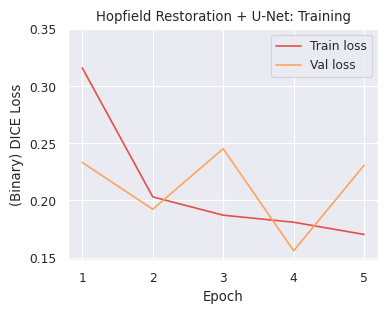

In [30]:
# Load the runtime stats.
stats = pd.read_csv('./models/hopfield-unet/saves/2024-03-13-(17-00-52)/stats.csv', header=None).rename(columns={0 : 'Epoch', 1 : 'Train loss', 2 : 'Val loss'})
stats['Epoch'] = stats['Epoch'] + 1

# Plot those fuckers.
fig, ax = plt.subplots(1, 1, figsize=(4,3))
sns.lineplot(data=stats, x='Epoch', y='Train loss', label='Train loss', ax=ax)
sns.lineplot(data=stats, x='Epoch', y='Val loss', label='Val loss', ax=ax)

# Beautify.
ax.set_title('Hopfield Restoration + U-Net: Training')
ax.set_ylabel('(Binary) DICE Loss')
ax.set_yticks(np.arange(.15, .36, step=.05))

plt.savefig('./models/hopfield-unet/saves/2024-03-13-(17-00-52)/loss-curves.pdf', bbox_inches='tight')

In [12]:
# Load the best model.
secondary_model.load_state_dict(torch.load('./models/hopfield-unet/saves/2024-03-13-(17-00-52)/model-state-dict.pt'))

<All keys matched successfully>

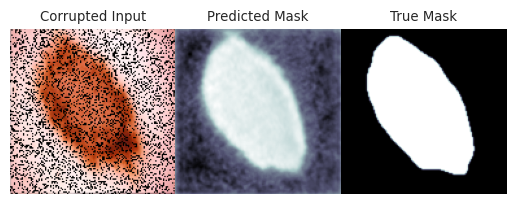

In [31]:
# Plot an example segmentation involving the Hopfield restoration pre-processing.
val_idx = 19
side_by_side_model_segmentation(secondary_model, val_dataset[val_idx])
plt.savefig(f'./models/hopfield-unet/saves/2024-03-13-(17-00-52)/segmentation-example-(val-{val_idx}).pdf', bbox_inches='tight')

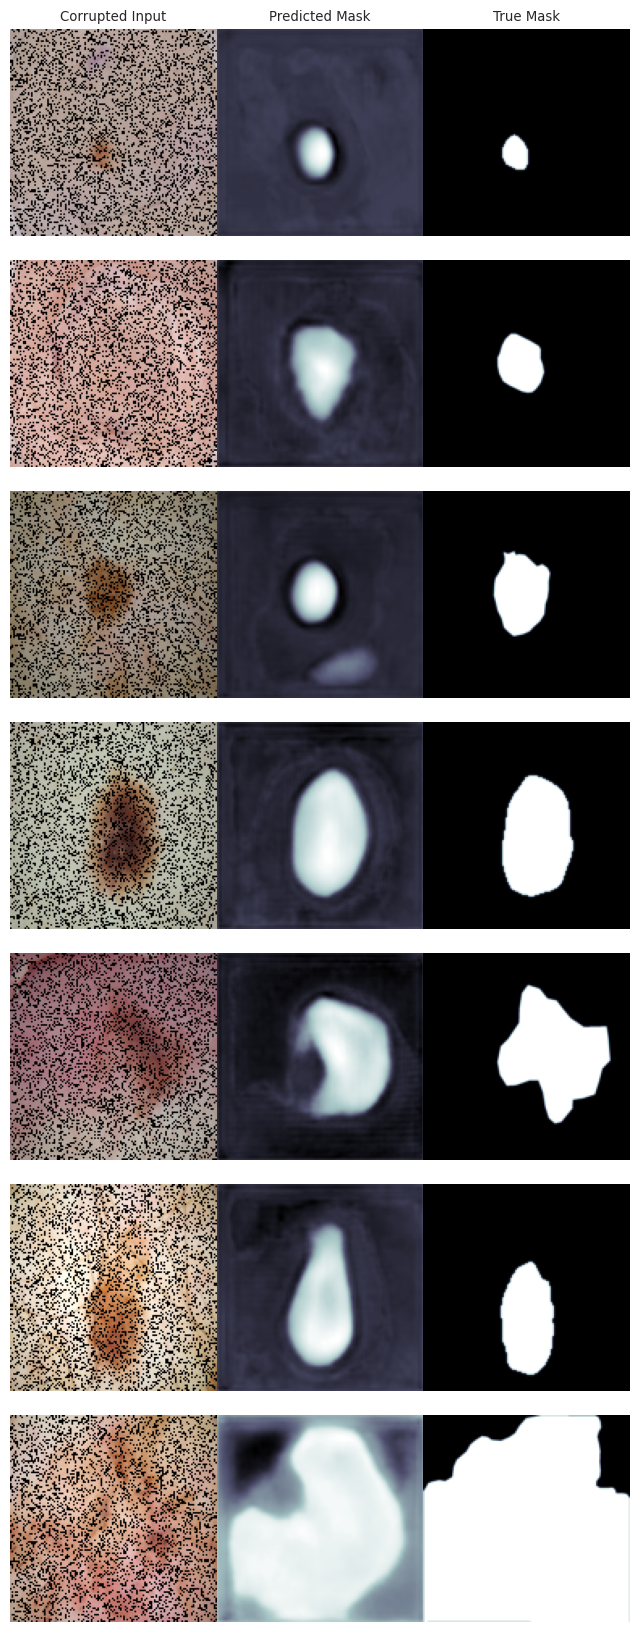

In [39]:
# Plot a collection of examples.
indices_to_plot = [3, 4, 5, 9, 10, 11, 19]

fig, axes = plt.subplots(len(indices_to_plot), 3, figsize=(8, 3*len(indices_to_plot)), gridspec_kw={'wspace': 0, 'hspace': 0})

cmap = 'bone'
for i, (ax1, ax2, ax3) in enumerate(axes):
    # Break apart the sample and move to device.
    example_input, example_target = val_dataset[i]
    example_input = example_input.reshape(1, 3, 128, 128).to('cuda')
    example_target = example_target.to('cuda')
    
    restored_input = hopfield_restoration_model(example_input)
    example_output, _ = secondary_model(restored_input, example_target)
    
    # Show them.
    ax1.imshow(example_input[0].detach().cpu().permute(1, 2, 0))
    ax2.imshow(example_output[0].detach().cpu().permute(1, 2, 0), cmap=cmap)
    ax3.imshow(example_target[0].detach().cpu(), cmap=cmap)
    
    # Memory saving.
    del example_input
    del example_target
    del restored_input
    del example_output
    
    # Beautify.
    ax1.axis('off')
    ax1.axis('tight')
    ax1.axis('image')
    ax2.axis('off')
    ax2.axis('tight')
    ax2.axis('image')
    ax3.axis('off')
    ax3.axis('tight')
    ax3.axis('image')
    
    # Put the titles on the top row.
    if i == 0:
        ax1.set_title('Corrupted Input')
        ax2.set_title('Predicted Mask')
        ax3.set_title('True Mask')
        
    else:
        ax1.set_title('')
        ax2.set_title('')
        ax3.set_title('')